# Mask to polygons

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from xview2comp.nb_02b import *
import imantics
from simplification.cutil import simplify_coords_vwp
from uuid import uuid4
import tqdm

In [3]:
show_install(True)



```text
=== Software === 
python       : 3.7.4
fastai       : 1.0.59
fastprogress : 0.1.21
torch        : 1.2.0
torch cuda   : None / is **Not available** 

=== Hardware === 
No GPUs available 

=== Environment === 
platform     : Darwin-19.0.0-x86_64-i386-64bit
conda env    : fastai_dev
python       : /Users/jack/anaconda3/envs/fastai_dev/bin/python
sys.path     : /Users/jack/git_repos/xview2comp
/Users/jack/anaconda3/envs/fastai_dev/lib/python37.zip
/Users/jack/anaconda3/envs/fastai_dev/lib/python3.7
/Users/jack/anaconda3/envs/fastai_dev/lib/python3.7/lib-dynload

/Users/jack/anaconda3/envs/fastai_dev/lib/python3.7/site-packages
/Users/jack/anaconda3/envs/fastai_dev/lib/python3.7/site-packages/IPython/extensions
/Users/jack/.ipython
../course-v3/nbs/dl2
no supported gpus found on this system
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.



In this notebook, we will:
* Convert a binary mask to a list/table of polygons in it.
* Generate a unique id for each of the polygon.
* For each polygon, crop out the part of the original image that lies underneath the polygon -- which we call the *polygon image*.
* Save each polygon image in an .png file named after its polygon's unique id.

In [4]:
SOURCE = Path('data/train/')
SOURCE.ls()

[PosixPath('data/train/train.tar.gz'),
 PosixPath('data/train/images'),
 PosixPath('data/train/damagemasks'),
 PosixPath('data/train/labels'),
 PosixPath('data/train/classification_images'),
 PosixPath('data/train/binarymasks')]

In [5]:
npreimgs = pre_img_fpaths(get_image_files(SOURCE/'images'))
npreimgs[:3]

[PosixPath('data/train/images/hurricane-harvey_00000015_pre_disaster.png'),
 PosixPath('data/train/images/hurricane-harvey_00000228_pre_disaster.png'),
 PosixPath('data/train/images/hurricane-michael_00000261_pre_disaster.png')]

In [6]:
nposimgs = [pre2post_fpath(n) for n in npreimgs]
nposimgs[:3]

[PosixPath('data/train/images/hurricane-harvey_00000015_post_disaster.png'),
 PosixPath('data/train/images/hurricane-harvey_00000228_post_disaster.png'),
 PosixPath('data/train/images/hurricane-michael_00000261_post_disaster.png')]

In [7]:
nposlabs = [img2label_fpath(n) for n in nposimgs]
nposlabs[:3]

[PosixPath('data/train/labels/hurricane-harvey_00000015_post_disaster.json'),
 PosixPath('data/train/labels/hurricane-harvey_00000228_post_disaster.json'),
 PosixPath('data/train/labels/hurricane-michael_00000261_post_disaster.json')]

### Grab a single sample  

Grab a single sample from the training set.  Get the paths to the pre-disaster image, the post-disaster image, the binary mask (which is made from the pre-disaster image's annotations).

In [8]:
idx = 23

In [9]:
npreimg = npreimgs[idx]
nposimg = pre2post_fpath(npreimgs[idx])
nbmask = img2bmask_fpath(npreimg)

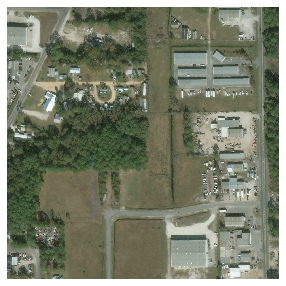

In [10]:
open_image(npreimg).show(figsize=(5, 5))

In [11]:
bmask = open_mask(nbmask)

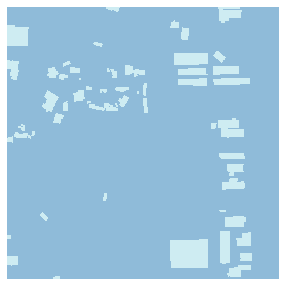

In [12]:
bmask.show(figsize=(5, 5))

#### Convert binary mask to polygon

This was already outlined in *01_load_data.ipynb*. Here, the procedures defined there are refactored into functions.

In [13]:
#export
def bmask2polys(mask):
    '''
    Convert mask to polys.
    mask: 2d numpy.ndarray 
    ps: np.array of np.arrays, containing all polygons', 
        their vertices' (x, y) coordinates.
    '''
    sz = mask.shape[0]
    ps = imantics.Mask(mask).polygons()
    ps = (p.reshape(-1, 2) for p in ps)
    ps = (simplify_coords_vwp(p, .3).astype(np.int32) for p in ps)
    return sz, np.array([np.concatenate((p, p[0][None,...])) for p in ps])

In [14]:
sz, polys = bmask2polys(bmask.data[0])

Convert the obtained polygons back to a binary mask to see if its' something close to the original binary mask.  

In [15]:
#export
def polys2bmask(polys, sz):
    '''
    Convert polygons to binary mask.
    polys: np.array of np.arrays, containing all polygons', 
        their vertices' (x, y) coordinates.
    mask: 2d numpy.ndarray
    '''
    mask = np.zeros((sz, sz), dtype=np.uint8)
    cv2.fillPoly(mask, polys, (1,));
    return mask

In [16]:
bmask_recon = polys2bmask(polys, sz)

Convert `np.array` binary mask to fastai's `ImageSegment` object.

In [17]:
bmask_recon = ImageSegment(tensor(bmask_recon[None,...]))

In [22]:
np.allclose(bmask_recon.data,  bmask.data), (bmask_recon.data != bmask.data).sum()

(False, tensor(1))

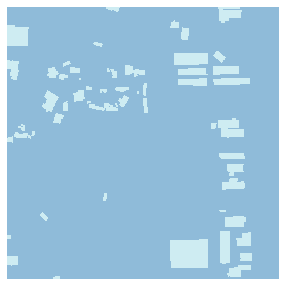

In [23]:
bmask_recon.show(figsize=(5, 5))

### Generate an id for each polygon

In [24]:
uid = uuid4()
uid

UUID('fde8f4d5-82d9-4561-a53f-52cf15bd12ab')

In [25]:
str(uid)

'fde8f4d5-82d9-4561-a53f-52cf15bd12ab'

In [26]:
uids = np.array([str(uuid4()) for _ in polys])

In [27]:
df_polys = pd.DataFrame({'uid':uids, 'polygon':polys})

We now have a table listing the polygons and their id:

In [28]:
df_polys.head()

,uid,polygon
0,6bb9e573-2bf4-45cf-8112-f4a36c737722,"[[180, 1011], [179, 1012], [179, 1014], [178, ..."
1,17f48f93-a97f-4458-a030-f4d2664a6bcc,"[[870, 971], [870, 979], [869, 980], [853, 980..."
2,25d1c0e9-4ca8-4b8b-852e-1e65850d9327,"[[0, 939], [0, 971], [13, 971], [14, 972], [15..."
3,213dffcd-d0b1-4b2e-a8f2-99726c220825,"[[894, 927], [893, 928], [878, 928], [878, 933..."
4,3c4895f5-6cdc-453c-b9ab-d82966f86029,"[[722, 875], [721, 876], [650, 876], [649, 877..."


### Get *polygon images*

The rectangular part of the original image in which a polygon just fits is called a *polygon* image.  In this section, we look at how to get a polygon image from a polygon and the image in which it sits.

In [29]:
polygon = df_polys.iloc[45].polygon
polygon

array([[198, 253],
       [198, 256],
       [197, 257],
       [197, 265],
       [196, 266],
       [196, 271],
       [204, 271],
       [205, 272],
       [213, 272],
       [213, 269],
       [212, 268],
       [212, 266],
       [213, 265],
       [219, 265],
       [220, 266],
       [227, 266],
       [227, 255],
       [220, 255],
       [219, 254],
       [206, 254],
       [205, 253],
       [198, 253]], dtype=int32)

In [30]:
posimg = open_image(nposimg)

In [31]:
#export
def crop_by_polygon(img:Image, polygon:np.ndarray, scale_pct=.8):
    '''
    Crop image by polygon
    img: image in which polygon lies.
    polygon: numpy array of (x, y) coordinates of vertices of polygon.
    '''
    width, height = img.size
    xs, ys = zip(*polygon)
    xmin, xmax, ymin, ymax = min(xs), max(xs), min(ys), max(ys)
    dx, dy = xmax - xmin, ymax - ymin
    ddx, ddy = scale_pct * dx, scale_pct * dy
    xmin, xmax = int(np.floor(xmin - ddx)), int(np.ceil(xmax + ddx))
    ymin, ymax = int(np.floor(ymin - ddy)), int(np.ceil(ymax + ddy))
    xmin, xmax = max(xmin, 0), min(xmax, width)
    ymin, ymax = max(ymin, 0), min(ymax, height)
    return Image(img.data[:,ymin:ymax,xmin:xmax])

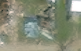

In [32]:
crop_by_polygon(posimg, polygon)

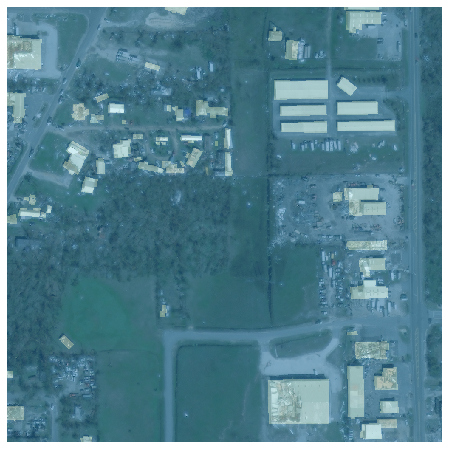

In [33]:
_, ax = plt.subplots(figsize=(8, 8))
posimg.show(ax)
bmask.show(ax, alpha=.5)

### Create damage classification dataset for training

Get all the polygon images from all the samples in the training set, and save them in folders named after their damamge level.  

For each sample:
1. Get the polygons from the post-disaster annotation.
2. Use the polygons to crop the post-disaster image.
3. Generate a unique id for each polygon.
4. Save each polygon image to a file named after its unique id.
5. Get the damamge level for each polygon.
6. Record each polygon, along with its id and damamge level.

In [34]:
idx = 567

In [35]:
nposimg, nposlab = nposimgs[idx], nposlabs[idx]

In [36]:
posimg = open_image(nposimg)

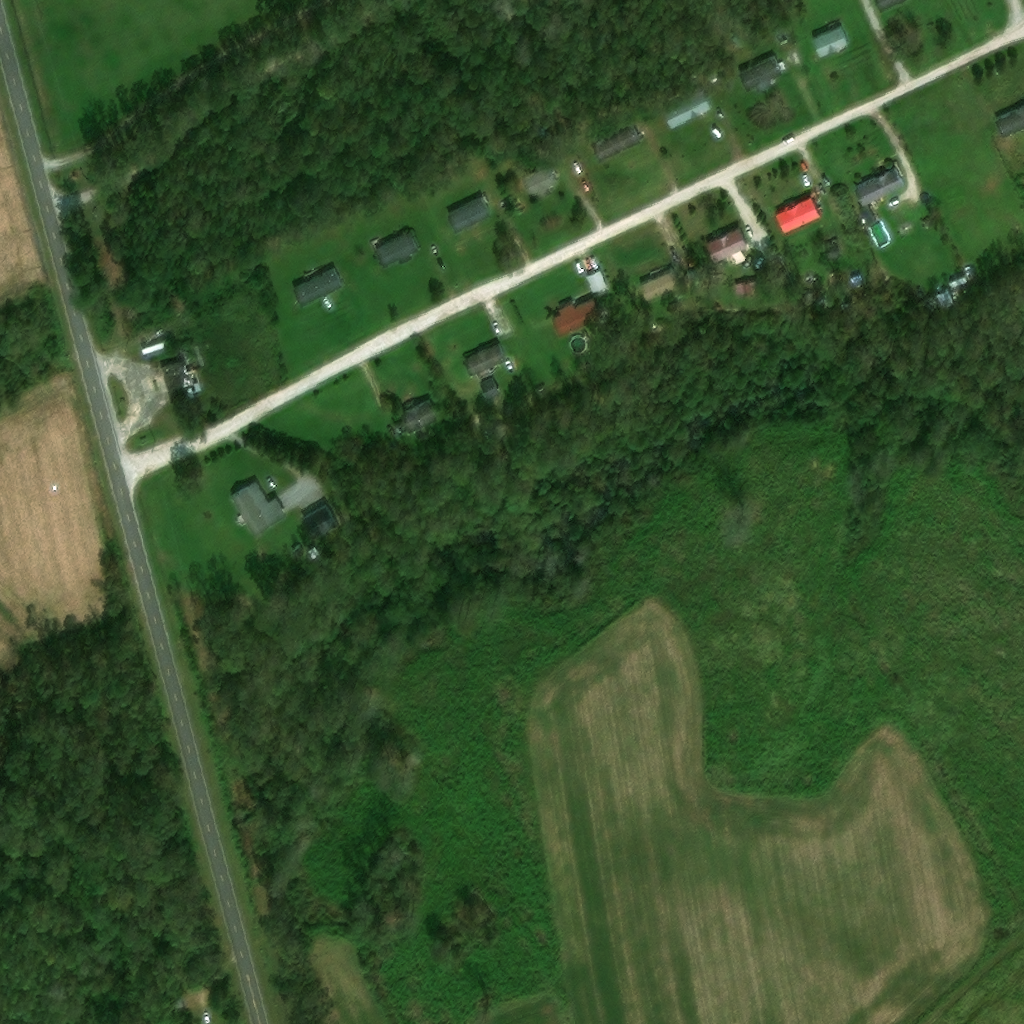

In [37]:
posimg

In [38]:
features = load_features(nposlab)

In [39]:
df_polys = features2df(features)

In [40]:
df_polys

,feature_type,subtype,uid,wkt
0,building,no-damage,cf81f65d-8be2-4cd3-bfd4-10b430857326,"POLYGON ((294.0527169865159 288.92518250582, 3..."
1,building,no-damage,3ed4931d-1a01-4738-a5a3-a515cdb7ff75,"POLYGON ((375.9940065130746 249.6047996579763,..."
2,building,no-damage,78961f49-dc90-4def-ac98-552f3ceaeea3,"POLYGON ((448.1402274485008 216.32151296038, 4..."
3,building,no-damage,82c1e04b-645f-43c5-a603-75292b4b90ea,"POLYGON ((522.5450297010043 178.9871309740203,..."
4,building,no-damage,84b4855f-40f3-437d-9ac8-800e7b3a6ecc,"POLYGON ((591.0928084448952 142.4845453481275,..."
5,building,no-damage,e0fb7d8b-ace0-42e0-a469-8e667cf412b5,"POLYGON ((662.7769222100458 109.6977543865035,..."
6,building,no-damage,9fc380fa-2d7d-48c6-97f0-b14c4826c0c9,"POLYGON ((739.2028210271374 73.89785771765553,..."
7,building,no-damage,f37a03f6-75e2-4334-8113-9bd79a947db1,"POLYGON ((730.9425967680698 38.11365813840203,..."
8,building,no-damage,53eb789d-c4a4-433d-b6d4-1007169fcdcd,"POLYGON ((812.4970096644 38.82293079500493, 84..."
9,building,no-damage,f01385f0-adee-4f07-a9ca-daf64049a3e8,POLYGON ((913.3453333189616 0.0077317252152298...


In [41]:
idx = 8

In [42]:
r = df_polys.iloc[idx]

In [43]:
#export
def wkt2array(wkt:str):
    '''
    Convert well-known text representation string 
    to array of (x,y) coords
    '''
    poly = shapely.wkt.loads(wkt)
    poly = shapely.geometry.mapping(poly)
    poly = np.array(poly['coordinates'][0], dtype=np.int32)
    return poly

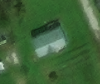

In [44]:
poly = wkt2array(r.wkt)
polyimg = crop_by_polygon(posimg, poly, )
polyimg

In [45]:
fname = f'{r.uid}.png'
fpath = SOURCE/'classification_images'/fname
fname, fpath

('53eb789d-c4a4-433d-b6d4-1007169fcdcd.png',
 PosixPath('data/train/classification_images/53eb789d-c4a4-433d-b6d4-1007169fcdcd.png'))

Test save this polygon image

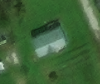

In [46]:
polyimg.save(fname)
open_image(fname)

We will also create a dataframe/csv to keep track of the damage level of each polygon image.

In [47]:
#export
class DamageCategorize():
    def __init__(self):
        self.o2i = {'un-classified':0, 'no-damage':0,
                    'minor-damage':1, 'major-damage':2, 'destroyed':3}
    def __call__(self, o): return self.o2i[o]

In [48]:
damgcats = DamageCategorize()

In [49]:
pd.Series({'uid': r.uid, 'damage': damgcats(r['subtype'])})

uid       53eb789d-c4a4-433d-b6d4-1007169fcdcd
damage                                       0
dtype: object

In [50]:
os.makedirs(SOURCE/'classification_images', exist_ok=True)

In [58]:
#export
def generate_classification_train():
    npreimgs = pre_img_fpaths(get_image_files(SOURCE/'images'))
    nposimgs = [pre2post_fpath(n) for n in npreimgs]
    nposlabs = [img2label_fpath(n) for n in nposimgs]
    
    nposimgs = nposimgs[:600] # just test 600 samples on the CPU
    nposlabs = nposlabs[:600]
     
    df = pd.DataFrame()
    for nposimg, nposlab in tqdm.tqdm(zip(nposimgs, nposlabs)):
        posimg = open_image(nposimg)
        feats = load_features(nposlab)
        df_polys = features2df(feats)
        for _, r in df_polys.iterrows():
            p = wkt2array(r.wkt)
            img = crop_by_polygon(posimg, p)
            fname = f'{r.uid}.png'
            fpath = SOURCE/'classification_images'/fname
            img.save(fpath)
            srs = pd.Series({'uid':r.uid, 'damage':r.subtype})
            df = df.append(srs, ignore_index=True)
    return df

In [59]:
%time
df = generate_classification_train()

0it [00:00, ?it/s]

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


600it [05:44,  1.74it/s]


In [60]:
df.iloc[idx]

damage                               no-damage
uid       5bffb7c0-8c21-4480-abc6-9ba080f24608
Name: 8, dtype: object

In [61]:
npolyimgs = (SOURCE/'classification_images').ls()

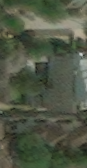

In [62]:
idx = 8

open_image(SOURCE/'classification_images'/f'{df.uid[idx]}.png')

In [65]:
df.to_csv('class_labels_small.csv')

In [68]:
len((SOURCE/'classification_images').ls()), df.shape

(36404, (36404, 2))

# -fin

In [56]:
! python notebook2script.py 02c_bmask_to_polygons.ipynb

Converted 02c_bmask_to_polygons.ipynb to xview2comp/nb_02c.py
